In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import math

<em><em>AlexNet model</em>

In [3]:
num_classes = 2

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        # Conv1
        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape, kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))
        # Conv2
        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal',name="conv2d_last"))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.SGD( momentum=0.5, nesterov=True, learning_rate=0.02),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

#50%#NO #optimizer= tf.keras.optimizers.Adam(0.001),
#50%#NO #RMSprop(learning_rate=0.01)
#50%#NO #Adagrad(learning_rate=0.1)
#loss: 0.6905 - accuracy: 0.5319 - val_loss: 0.6969 - val_accuracy: 0.4900 #YES #Adadelta(learning_rate=1.0)
#loss: 0.6226 - accuracy: 0.6758 - val_loss: 0.7441 - val_accuracy: 0.5150 #YES #tf.keras.optimizers.SGD( momentum=0.5, nesterov=True, learning_rate=0.02)

model = AlexNet((224, 224, 3), num_classes)
model.summary()
print("AlexNet")

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_last (Conv2D)         (None, 12, 12, 256)       884

In [4]:
# some training parameters

from pathlib import Path

EPOCHS = 20
BATCH_SIZE = 30
image_height = 224
image_width = 224
train_dir = Path("datasets", "train")
valid_dir = Path("datasets", "validation")
model_dir = "my_model.h5"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical")


train_num = train_generator.samples
valid_num = valid_generator.samples

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


<em>Training parameters and training process<em></em>

In [6]:
model.fit(train_generator,
          epochs=EPOCHS,
          steps_per_epoch=train_num // BATCH_SIZE,
          validation_data=valid_generator,
          validation_steps=valid_num // BATCH_SIZE,
          verbose=1)

# save the model
model.save(model_dir)

Epoch 1/20
32/32 [==============================] - 29s 922ms/step - loss: 0.9506 - accuracy: 0.4927 - val_loss: 0.6947 - val_accuracy: 0.4333

<em>Class-wise accuracies computing cell<em></em>

In [8]:
BATCH_SIZE_TEST=1
test_dir = Path("datasets", "test")
#__________________________________________________________
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_height, image_width),
                                                  color_mode="rgb",
                                                  shuffle = False,
                                                  class_mode="categorical",
                                                  batch_size=BATCH_SIZE_TEST)

test_num = test_generator.samples

#####Getting original labels#####

number_of_examples = len(test_generator.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE_TEST))
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_generator[i][1]))

#__________Getting predictions______________
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)


Found 300 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [9]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

<em>Evaluation of class-wise accuracies<em></em>

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predict = np.array(predict, dtype=np.float32)
predict_indices = np.zeros((len(predict)))
for i in range(len(predict_indices)):
    predict_indices[i] = np.argmax(predict[i])

test_labels_np = np.asarray(test_labels)
test_labels_indices = np.zeros((len(test_labels_np)))
for i in range(len(test_labels_indices)):
    test_labels_indices[i] = np.argmax(test_labels_np[i])

matrix_confusion = confusion_matrix(test_labels_indices,predict_indices)
print("Class-wise accuracies\n")
class_wise_accuracies = matrix_confusion.diagonal()/matrix_confusion.sum(axis=1)
for i in range(len(class_wise_accuracies)):
    print("Class " + str(i) + " accuracy: " + str(class_wise_accuracies[i]))

print("\nClassification_report")
target_names = []
for i in range(num_classes):
    target_names.append("Class " +str(i))
print(classification_report(test_labels_indices, predict_indices, target_names=target_names))


Class-wise accuracies

Class 0 accuracy: 0.02
Class 1 accuracy: 1.0

Classification_report
              precision    recall  f1-score   support

     Class 0       1.00      0.02      0.04       150
     Class 1       0.51      1.00      0.67       150

    accuracy                           0.51       300
   macro avg       0.75      0.51      0.36       300
weighted avg       0.75      0.51      0.36       300



In [11]:
import random
#Getting sample per class
while_swicher=True
images_per_class=[]
for i in range(num_classes):
    while(while_swicher):
        x,y = test_generator.next()
        if(np.where(y == 1)[1][0]==i):
            range_random=random.randint(1, 50)
            for jj in range(range_random):
                x,y = test_generator.next()
            images_per_class.append(x)
            while_swicher=False
    while_swicher=True
print("Random samples were obtained ")

Random samples were obtained 


<em>Visualizing Activation Heatmaps due to Grad-Cam (Gradient Class Activation Map)<em></em>

Class 0
Clear image


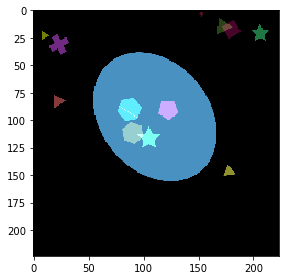

C:\Users\steba\anaconda3\envs\tf_CPU\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image + heatmap
Version of visualization №1


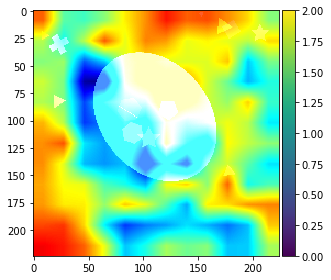

Version of visualization №2


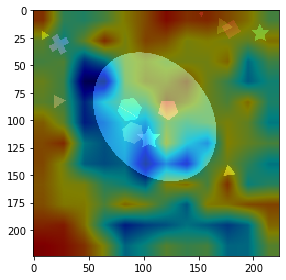

Class 1
Clear image


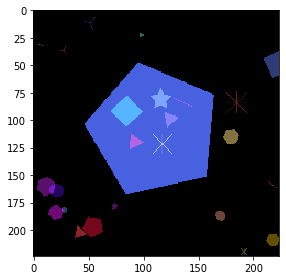

Image + heatmap
Version of visualization №1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


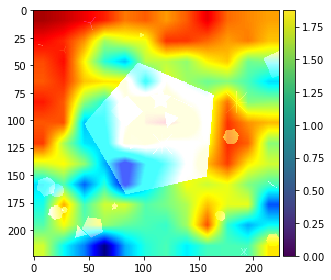

Version of visualization №2


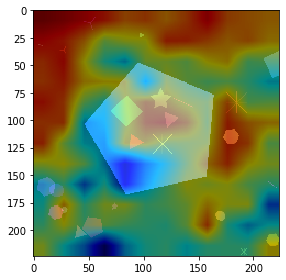

In [12]:
import tensorflow.keras.backend as K
import cv2


#Getting sample per class

def gradCAM(x,print_images=False):
    image = x[0]
    if print_images:
        print("Clear image")
        imshow(image)

    with tf.GradientTape() as tape:
        #Getting last convolution layer
        last_conv_layer = model.get_layer('conv2d_last')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((12, 12))

    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    if print_images:
        print("Image + heatmap")
        print("Version of visualization №1")
        heatmap = heatmap/255
        img = heatmap + image
        imshow(img)
        print("Version of visualization №2")
        img_reshaped = np.reshape(img,-1)
        img = img/img_reshaped[np.argmax(img_reshaped)]
        imshow(img)


    return heatmap


for i in range(num_classes):
    print("Class %d"%(i))
    gradCAM(images_per_class[i],True)



In [13]:
heatmaps_number = 31 #number of heatmaps that will be created

heatmaps_of_images = [[0 for j in range(heatmaps_number)] for i in range(num_classes)]
heatmaps_number = heatmaps_number-1
corrcoef_pearsonr = [[0 for j in range(heatmaps_number)] for i in range(num_classes)]
corrcoef_spearmanr = [[0 for j in range(heatmaps_number)] for i in range(num_classes)]
#Adding first heatmaps
for i in range(num_classes):
    heatmaps_of_images[i][0]=gradCAM(images_per_class[i],False)

In [14]:
#Investigation of significance of the effect of noise on the heatmaps
import scipy.stats

def add_noise_to_image(image, mean = 0,var = 0.01):
    row,col,ch= image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

mean = np.arange(0.0, 1.0, 1/len(corrcoef_pearsonr[0]))
print("I'm adding the gaussian noise to images changing mean")
for j in range(num_classes):
    noisy_image = np.ones_like(images_per_class[0])
    for i in range(len(corrcoef_pearsonr[0])):

        noisy_image[0] = add_noise_to_image(images_per_class[j][0],mean[i])
        heatmaps_of_images[j][i+1] = gradCAM(noisy_image,False)

        corrcoef_pearsonr[j][i] = scipy.stats.pearsonr(np.reshape(heatmaps_of_images[j][0], [-1]), np.reshape(heatmaps_of_images[j][i+1], [-1]))[0]
        corrcoef_spearmanr[j][i] = scipy.stats.spearmanr(np.reshape(heatmaps_of_images[j][0], [-1]), np.reshape(heatmaps_of_images[j][i+1], [-1]))[0]

        #imshow(noisy_image[0])
        #imshow(heatmaps_of_images[j][i+1])


I'm adding the gaussian noise to images changing mean


<em>Heatmaps visualisation<em></em>


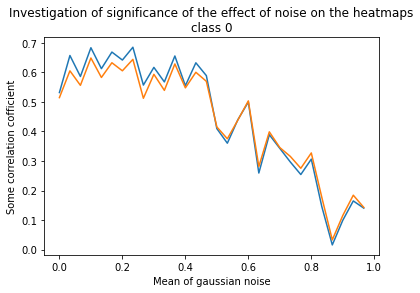

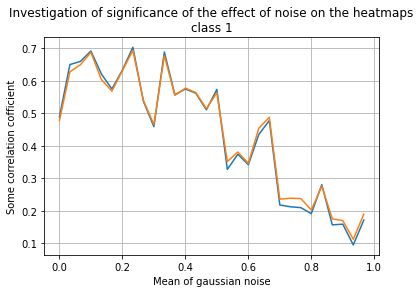

In [15]:
import matplotlib.pyplot as plt

def print_statistic(corrcoef_pearsonr,corrcoef_spearmanr,mean):
    horisontal = mean

    for i in range(len(corrcoef_pearsonr)):
        fig, ax = plt.subplots()
        ax.plot(horisontal,corrcoef_pearsonr[i],)
        ax.plot(horisontal,corrcoef_spearmanr[i])
        ax.set(xlabel='Mean of gaussian noise', ylabel='Some correlation cofficient',
               title='Investigation of significance of the effect of noise on the heatmaps\nclass %d'%i)
    ax.grid()
    plt.show()

print_statistic(corrcoef_pearsonr,corrcoef_spearmanr,mean)